# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\poorna\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\poorna\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import pandas as pd

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('D:/AAIC/Data_Sets/amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

## UpSampling the datausing resample

In [15]:
df_majority = final[final.Score==1]
df_minority = final[final.Score==0]

In [16]:
#Referred: https://elitedatascience.com/imbalanced-classes
from sklearn.utils import resample

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=73592,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.Score.value_counts()

1    73592
0    73592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = df_upsampled['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = df_upsampled['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = df_upsampled['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = df_upsampled['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
They were a big hit with our meeting attendees and tied in well with our mountain/nature theme.  Nice serving size for 1-2 people to share.
I found the product to be very good. My daughter was baking muffins for school and we use this product. The product was useful with the muffins. It gave the product a good taste to eat and we enjoyed eating the product.
I use lemon zest in a lot of my baking recipes.  I like to add a little bit of this lemon oil, in addition to lemon zest.  My results yield a heartier dose of lemon flavor, that taste completely natural-- which it is!


In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
They were a big hit with our meeting attendees and tied in well with our mountain/nature theme.  Nice serving size for 1-2 people to share.
I found the product to be very good. My daughter was baking muffins for school and we use this product. The product was useful with the muffins. It gave the product a good taste to eat and we enjoyed eating the product.
I use lemon zest in a lot of my baking recipes.  I like to add a little bit of this lemon oil, in addition to lemon zest.  My results yield a heartier dose of lemon flavor, that taste completely natural-- which it is!


In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I found the product to be very good. My daughter was baking muffins for school and we use this product. The product was useful with the muffins. It gave the product a good taste to eat and we enjoyed eating the product.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I found the product to be very good My daughter was baking muffins for school and we use this product The product was useful with the muffins It gave the product a good taste to eat and we enjoyed eating the product 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df_upsampled['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████| 147184/147184 [01:10<00:00, 2083.85it/s]


In [26]:
preprocessed_reviews[1500]

'found product good daughter baking muffins school use product product useful muffins gave product good taste eat enjoyed eating product'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [31]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.3] TF-IDF

## [4.4] Word2Vec

In [32]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## Information Gain:
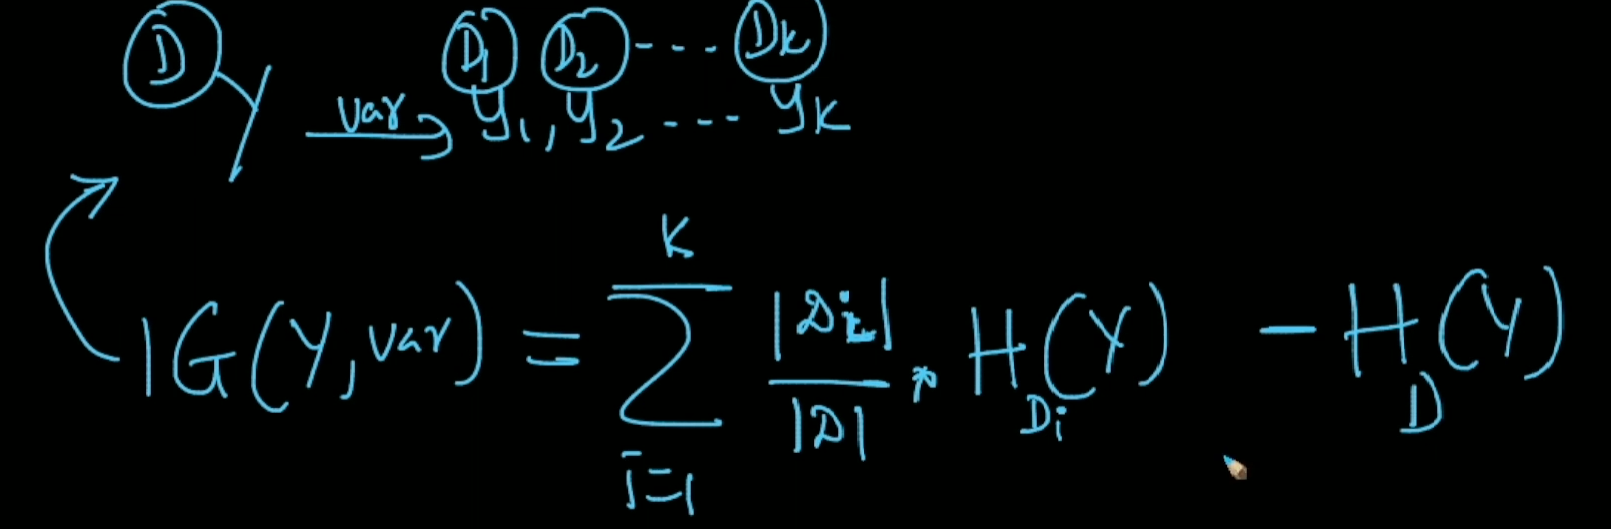

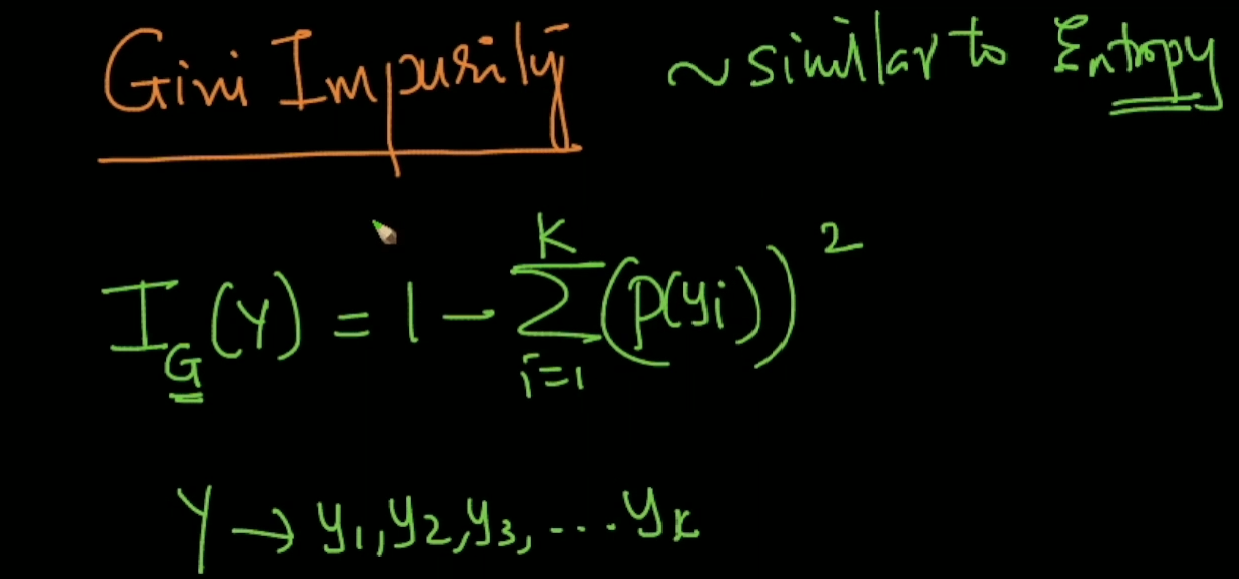

### There are two way to interpret Decision Trees .i.e., using Information Gain and Gini Impurity
Information Gain: Information gain is measured as difference between entropy of parent node and sum of Entropy at child nodes
* Entropy is measured on basis of probability distribution of variables .i.e., if a random variable is equiprobable then entropy will be maximum and if PDF of variable is peaked at one part then Entropy will be minimum (or around zero). (Given by 'H(Y)' in first image).
<font color='green'>In Other words, It measures the uncertainity of the variable</font>
* So, as given by the definition of Information gain, intuitively it gives, how important the given variable and its splits. 

#### Difference between min_samples_split and min_samples_leaf:
* If min_samples_leaf = 2 amd min_samples_split = 5, Internal node classifying 7 samples into 6 and 1 will not be qulifying as leaf node as one of the node has less than min_samples_leaf
* min_samples_split  - specifies the minimum number of samples required to split an internal node
* min_samples_leaf - specifies the minimum number of samples required to be at a leaf node.

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [27]:
len(preprocessed_reviews)

147184

In [28]:
#divide preprocessed review data to Train and Test dataset using train_test_split
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, Y_train, Y_test = train_test_split(preprocessed_reviews,df_upsampled['Score'].values,test_size=0.3,shuffle=True)
X_train_split, X_CV, Y_train_split, Y_CV = train_test_split(X_train,Y_train,test_size=0.2,shuffle=False)
#print(X_train.shape, Y_tra)
print(pd.DataFrame(Y_train_split)[0].value_counts())
print(pd.DataFrame(Y_CV)[0].value_counts())
print(pd.DataFrame(Y_test)[0].value_counts())

1    41344
0    41078
Name: 0, dtype: int64
0    10324
1    10282
Name: 0, dtype: int64
0    22190
1    21966
Name: 0, dtype: int64


In [29]:
#BoW
#ngram_range=(1,2), min_df=10, max_features=5000
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train_split)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_split_vec = count_vect.transform(X_train_split)
X_CV_vec = count_vect.transform(X_CV)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_split_vec))
print("the number of unique words ", X_train_split_vec.get_shape()[1])
print(X_train_split_vec.shape,X_CV_vec.shape,X_test_vec.shape,Y_train_split.shape,Y_CV.shape,Y_test.shape)

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words  44252
(82422, 44252) (20606, 44252) (44156, 44252) (82422,) (20606,) (44156,)


In [30]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate until the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [31]:
# Please write all the code with proper documentation
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

max_depth_bow = [1, 5, 10, 50, 100, 500, 1000]
min_samples_split = [5, 10, 100, 500]
Y_pred_bow_tr = []
Y_pred_bow_cv = []
auc_bow_tr=[]
auc_bow_cv=[]

for depth in max_depth_bow:
    for min_sam in min_samples_split:
        clf = DecisionTreeClassifier(random_state=0, min_samples_split = min_sam, max_depth=depth, criterion="gini")
        clf.fit(X_train_split_vec, Y_train_split)
        #Predict on train data - Probability Values
        Y_pred_bow_tr = batch_predict(clf, X_train_split_vec)
        #Predict on CV data - Probability vlaues
        Y_pred_bow_cv = batch_predict(clf, X_CV_vec)
         #Get AUC Value for train data
        fpr_tr, tpr_tr, _ = roc_curve(Y_train_split, Y_pred_bow_tr)
        temp_auc_tr = auc(fpr_tr, tpr_tr)
        auc_bow_tr.append(temp_auc_tr)
        #Get AUC Value
        fpr_ts, tpr_ts, _ = roc_curve(Y_CV, Y_pred_bow_cv)
        temp_auc_cv = auc(fpr_ts, tpr_ts)
        auc_bow_cv.append(temp_auc_cv)
        print("max_dept: %d min_samples: %d AUC_Train: %0.4f AUC_CV: %0.4f"%(depth, min_sam, temp_auc_tr, temp_auc_cv))

max_dept: 1 min_samples: 5 AUC_Train: 0.6257 AUC_CV: 0.6251
max_dept: 1 min_samples: 10 AUC_Train: 0.6257 AUC_CV: 0.6251
max_dept: 1 min_samples: 100 AUC_Train: 0.6257 AUC_CV: 0.6251
max_dept: 1 min_samples: 500 AUC_Train: 0.6257 AUC_CV: 0.6251
max_dept: 5 min_samples: 5 AUC_Train: 0.7393 AUC_CV: 0.7359
max_dept: 5 min_samples: 10 AUC_Train: 0.7393 AUC_CV: 0.7359
max_dept: 5 min_samples: 100 AUC_Train: 0.7390 AUC_CV: 0.7355
max_dept: 5 min_samples: 500 AUC_Train: 0.7386 AUC_CV: 0.7353
max_dept: 10 min_samples: 5 AUC_Train: 0.8201 AUC_CV: 0.8068
max_dept: 10 min_samples: 10 AUC_Train: 0.8197 AUC_CV: 0.8060
max_dept: 10 min_samples: 100 AUC_Train: 0.8125 AUC_CV: 0.8039
max_dept: 10 min_samples: 500 AUC_Train: 0.8067 AUC_CV: 0.8017
max_dept: 50 min_samples: 5 AUC_Train: 0.9861 AUC_CV: 0.8983
max_dept: 50 min_samples: 10 AUC_Train: 0.9839 AUC_CV: 0.8989
max_dept: 50 min_samples: 100 AUC_Train: 0.9558 AUC_CV: 0.8963
max_dept: 50 min_samples: 500 AUC_Train: 0.9088 AUC_CV: 0.8784
max_dept: 10

In [32]:
XLabels=[]
for depth in max_depth_bow:
    for min_sam in min_samples_split:
        temp = str(depth)+"/"+str(min_sam)
        XLabels.append(temp)

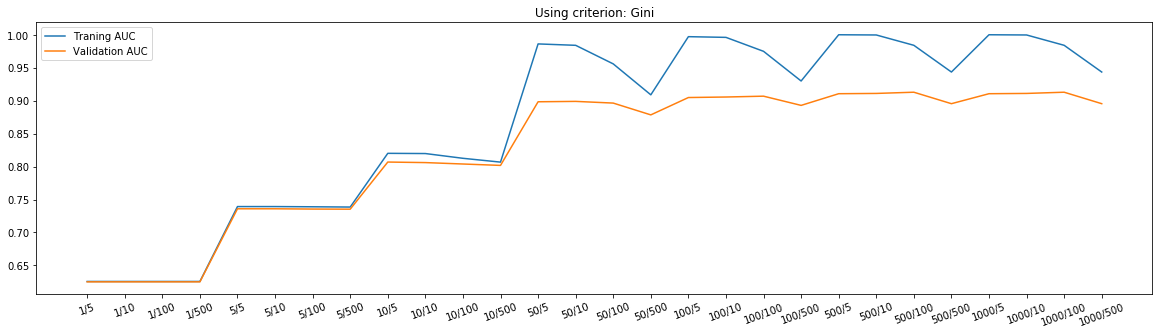

In [33]:
plt.figure(figsize=(20,5))
plt.plot(range(len(XLabels)), auc_bow_tr)
plt.plot(range(len(XLabels)), auc_bow_cv)
plt.xticks(range(len(XLabels)), XLabels, rotation = 20)
plt.title("Using criterion: Gini")
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

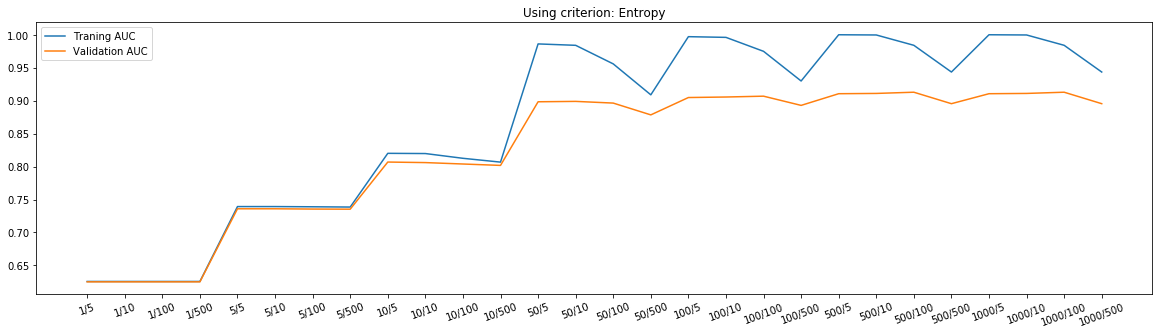

In [34]:
plt.figure(figsize=(20,5))
plt.plot(range(len(XLabels)), auc_bow_tr)
plt.plot(range(len(XLabels)), auc_bow_cv)
plt.xticks(range(len(XLabels)), XLabels, rotation = 20)
plt.legend(['Traning AUC', 'Validation AUC'])
plt.title("Using criterion: Entropy")
plt.show()

##### A small variation can be seen between criterion being "Gini" and "Entropy" (around 100/500 and 500/500)

#### min_samples_split = 10 and max_depth = 500 Criterion = "Gini"

In [35]:
DT_clf = DecisionTreeClassifier(random_state=0, min_samples_split = 10, max_depth=500)
DT_clf.fit(X_train_split_vec,Y_train_split)
Y_pred_tr = DT_clf.predict(X_train_split_vec)
auc_opt_tr_bow = roc_auc_score(Y_train_split, Y_pred_tr)
Y_pred_test = DT_clf.predict(X_test_vec)
auc_opt_test_bow = roc_auc_score(Y_test, Y_pred_test)
print("AUC value of train data: ",auc_opt_tr_bow)
print("AUC value of test data: ", auc_opt_test_bow)

AUC value of train data:  0.9891247403612353
AUC value of test data:  0.8988481481704877


In [42]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(Y_train_split, Y_pred_tr)
fpr_test, tpr_test, _ = roc_curve(Y_test, Y_pred_test)
auc_opt_bow_tr = auc(fpr, tpr)
auc_opt_bow_test = auc(fpr_test, tpr_test)

In [73]:
def plotROC(fpr, tpr, fpr_test, tpr_test, auc_tr, auc_test): 
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC on train data = %0.3f' % auc_tr)
    plt.plot(fpr_test, tpr_test, 'g', label = 'AUC on test data = %0.3f' % auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

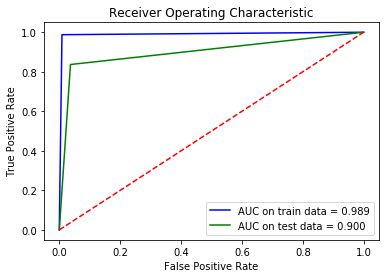

In [74]:
plotROC(fpr, tpr, fpr_test, tpr_test, auc_opt_bow_tr, auc_opt_bow_test)

In [75]:
#confusion matirx
import scikitplot.metrics as skplt

def plotConfusion(Y_tr,Y_prob_tr, Y_ts, Y_prob_ts):
    # for train data prediction
    skplt.plot_confusion_matrix(Y_tr, Y_prob_tr)
    #for test data prediction
    skplt.plot_confusion_matrix(Y_ts, Y_prob_ts)

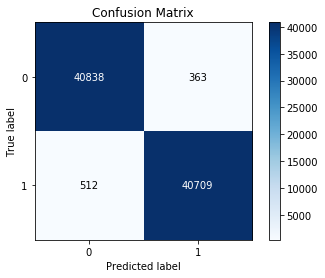

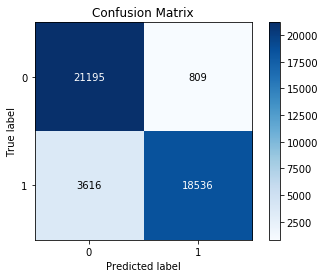

In [76]:
plotConfusion(Y_train_split, Y_pred_tr,Y_test,Y_pred_test)

In [77]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision of test: %0.4f"%(precision_score(Y_test, Y_pred_test)))
print("Recall of test: %0.4f"%(recall_score(Y_test, Y_pred_test)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test, Y_pred_test)))

Precision of test: 0.9582
Recall of test: 0.8368
F1 Score of test: 0.8934


### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [82]:
# Feature importance function for Decision Trees :
def show_most_informative_features(vectorizer, model):
    feat_names = vectorizer.get_feature_names()
    weights = model.feature_importances_
    df = pd.DataFrame(data = weights, columns=['Value'], index=feat_names)
    df.sort_values(by='Value', ascending=False, inplace=True)
    return df.head(20)

In [83]:
show_most_informative_features(count_vect, DT_clf)

,Value
not,0.088868
great,0.053966
best,0.022952
delicious,0.022718
love,0.017693
perfect,0.015769
good,0.014519
loves,0.012534
disappointed,0.011578
excellent,0.009053


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [42]:
os.sys.platform

'win32'

In [43]:
os.environ

environ{'ALLUSERSPROFILE': 'C:\\ProgramData',
        'APPDATA': 'C:\\Users\\poorna\\AppData\\Roaming',
        'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files',
        'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files',
        'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files',
        'COMPUTERNAME': 'BOLT',
        'COMSPEC': 'C:\\Windows\\system32\\cmd.exe',
        'EASYPLUSSDK': '"C:\\Program Files (x86)\\Common Files\\lenovo\\easyplussdk\\bin"',
        'FP_NO_HOST_CHECK': 'NO',
        'HOMEDRIVE': 'C:',
        'HOMEPATH': '\\Users\\poorna',
        'LOCALAPPDATA': 'C:\\Users\\poorna\\AppData\\Local',
        'LOGONSERVER': '\\\\MicrosoftAccount',
        'NUMBER_OF_PROCESSORS': '4',
        'ONLINESERVICES': 'Online Services',
        'OS': 'Windows_NT',
        'PATH': 'C:\\Users\\poorna\\Anaconda3;C:\\Users\\poorna\\Anaconda3\\Library\\mingw-w64\\bin;C:\\Users\\poorna\\Anaconda3\\Library\\usr\\bin;C:\\Users\\poorna\\Anaconda3\\Library\\bin;C:\\

In [ ]:
os.environ['PROGRAMFILES(X86)'], 'ATT', 'GraphViz', 'bin'

In [48]:
import os
os.environ['PATH'].split(os.pathsep)

['C:\\Users\\poorna\\Anaconda3',
 'C:\\Users\\poorna\\Anaconda3\\Library\\mingw-w64\\bin',
 'C:\\Users\\poorna\\Anaconda3\\Library\\usr\\bin',
 'C:\\Users\\poorna\\Anaconda3\\Library\\bin',
 'C:\\Users\\poorna\\Anaconda3\\Scripts',
 'C:\\Users\\poorna\\OpenCV\\opencv\\build\\x64\\vc14\\bin',
 'C:\\Users\\poorna\\AppData\\Local\\Programs\\Python\\Python36\\Scripts\\',
 'C:\\Users\\poorna\\AppData\\Local\\Programs\\Python\\Python36\\',
 'C:\\Users\\poorna\\AppData\\Local\\Programs\\Python\\Python37\\Scripts\\',
 'C:\\Users\\poorna\\AppData\\Local\\Programs\\Python\\Python37\\',
 'C:\\Users\\poorna\\Anaconda3',
 'C:\\Users\\poorna\\Anaconda3\\Library\\mingw-w64\\bin',
 'C:\\Users\\poorna\\Anaconda3\\Library\\usr\\bin',
 'C:\\Users\\poorna\\Anaconda3\\Library\\bin',
 'C:\\Users\\poorna\\Anaconda3\\Scripts',
 'C:\\Program Files\\Java\\jdk1.8.0_51\\bin',
 'C:\\Program Files\\Microsoft VS Code\\bin',
 'C:\\Program Files\\CMake\\bin',
 'C:\\Users\\poorna\\Anaconda3\\lib\\site-packages\\numpy\\

In [45]:
os.path.join(os.environ['PROGRAMFILES(X86)'], 'Graphviz2.38', 'bin','gvedit.exe')

'C:\\Program Files (x86)\\Graphviz2.38\\bin\\gvedit.exe'

In [ ]:
C:\Program Files (x86)\Graphviz2.38\bin\gvedit.exe

In [47]:
os.environ['PATH'] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\gvedit.exe'

In [38]:
os.environ['PATH'] += os.pathsep + 'C:\\Users\\poorna\\Anaconda3\\Library\\bin\\graphviz'

In [49]:
# Please write all the code with proper documentation
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus
import graphviz

feat_names = count_vect.get_feature_names()

dot_data = StringIO()
export_graphviz(DT_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feat_names,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('BOW_trees.png')

Image(graph.create_png())

InvocationException: Program terminated with status: 255. stderr follows: []

export_graphviz(dtree, out_file=dot_data, 
 filled=True, rounded=True,
 special_characters=True, feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
import collections
import pydotplus

# Visualize data
dot_data = tree.export_graphviz(DT_clf,
                                feature_names=data_feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree.png')

In [40]:
###visualize and analyze the tree model###
###build a file to visualize 
from sklearn.tree import export_graphviz
export_graphviz(DT_clf,out_file="mytree.dot",feature_names = feat_names,class_names=['0','1'],impurity=False,filled=True)
###visualize the .dot file. Need to install graphviz seperately at first 
import graphviz
with open("mytree.dot") as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [84]:
import pickle
filename = 'DT_opt_bow.sav'
pickle.dump(DT_clf, open(filename, 'wb'))

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [51]:
#divide preprocessed review data to Train and Test dataset using train_test_split
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, Y_train, Y_test = train_test_split(preprocessed_reviews,df_upsampled['Score'].values,test_size=0.3,shuffle=True)
X_train_split, X_CV, Y_train_split, Y_CV = train_test_split(X_train,Y_train,test_size=0.2,shuffle=False)
#print(X_train.shape, Y_tra)
print(pd.DataFrame(Y_train_split)[0].value_counts())
print(pd.DataFrame(Y_CV)[0].value_counts())
print(pd.DataFrame(Y_test)[0].value_counts())

1    41212
0    41210
Name: 0, dtype: int64
1    10339
0    10267
Name: 0, dtype: int64
0    22115
1    22041
Name: 0, dtype: int64


In [52]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train_split)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_split_vec = tf_idf_vect.transform(X_train_split)
X_CV_Vec = tf_idf_vect.transform(X_CV)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_split_vec))
print("the shape of out text TFIDF vectorizer ",X_train_split_vec.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_split_vec.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandoned', 'abc', 'abdominal', 'abilities', 'ability', 'able', 'able add']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (82422, 56670)
the number of unique words including both unigrams and bigrams  56670


In [53]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate until the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [56]:
# Please write all the code with proper documentation
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

max_depth = [1, 5, 10, 50, 100, 500, 1000]
min_samples_split = [5, 10, 100, 500]
Y_pred_tf_tr = []
Y_pred_tf_cv = []
auc_tf_tr=[]
auc_tf_cv=[]

for depth in max_depth:
    for min_sam in min_samples_split:
        temp = str(depth)+"/"+str(min_sam)
        XLabels.append(temp)
        clf = DecisionTreeClassifier(random_state=0, min_samples_split = min_sam, max_depth=depth, criterion="gini")
        clf.fit(X_train_split_vec, Y_train_split)
        #Predict on train data - Probability Values
        Y_pred_tf_tr = batch_predict(clf, X_train_split_vec)
        #Predict on CV data - Probability vlaues
        Y_pred_tf_cv = batch_predict(clf, X_CV_Vec)
         #Get AUC Value for train data
        fpr_tr, tpr_tr, _ = roc_curve(Y_train_split, Y_pred_tf_tr)
        temp_auc_tr = auc(fpr_tr, tpr_tr)
        auc_tf_tr.append(temp_auc_tr)
        #Get AUC Value
        fpr_ts, tpr_ts,_ = roc_curve(Y_CV, Y_pred_tf_cv)
        temp_auc_cv = auc(fpr_ts, tpr_ts)
        auc_tf_cv.append(temp_auc_cv)
        print("max_dept: %d min_samples: %d AUC_Train: %0.4f AUC_CV: %0.4f"%(depth, min_sam, temp_auc_tr, temp_auc_cv))

max_dept: 1 min_samples: 5 AUC_Train: 0.6246 AUC_CV: 0.6308
max_dept: 1 min_samples: 10 AUC_Train: 0.6246 AUC_CV: 0.6308
max_dept: 1 min_samples: 100 AUC_Train: 0.6246 AUC_CV: 0.6308
max_dept: 1 min_samples: 500 AUC_Train: 0.6246 AUC_CV: 0.6308
max_dept: 5 min_samples: 5 AUC_Train: 0.7424 AUC_CV: 0.7424
max_dept: 5 min_samples: 10 AUC_Train: 0.7424 AUC_CV: 0.7424
max_dept: 5 min_samples: 100 AUC_Train: 0.7420 AUC_CV: 0.7420
max_dept: 5 min_samples: 500 AUC_Train: 0.7414 AUC_CV: 0.7420
max_dept: 10 min_samples: 5 AUC_Train: 0.8192 AUC_CV: 0.8039
max_dept: 10 min_samples: 10 AUC_Train: 0.8191 AUC_CV: 0.8042
max_dept: 10 min_samples: 100 AUC_Train: 0.8122 AUC_CV: 0.8030
max_dept: 10 min_samples: 500 AUC_Train: 0.8092 AUC_CV: 0.8025
max_dept: 50 min_samples: 5 AUC_Train: 0.9834 AUC_CV: 0.9070
max_dept: 50 min_samples: 10 AUC_Train: 0.9818 AUC_CV: 0.9090
max_dept: 50 min_samples: 100 AUC_Train: 0.9611 AUC_CV: 0.9076
max_dept: 50 min_samples: 500 AUC_Train: 0.9262 AUC_CV: 0.8909
max_dept: 10

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(range(len(XLabels[:28])), auc_tf_tr)
plt.plot(range(len(XLabels[:28])), auc_tf_cv)
plt.xticks(range(len(XLabels[:28])), XLabels[:28], rotation = 20)
plt.legend(['Traning AUC', 'Validation AUC'])
plt.title("Using criterion as Gini")
plt.show()

#### min_samples_split = 50 and max_depth = 500 Criterion = "Gini"

In [ ]:
DT_clf_tf = DecisionTreeClassifier(random_state=0, min_samples_split = 50, max_depth=500)
DT_clf_tf.fit(X_train_split_vec,Y_train_split)
Y_pred_tr = DT_clf_tf.predict_proba(X_train_split_vec)
auc_opt_tr_tf = roc_auc_score(Y_train_split, Y_pred_tr)
Y_pred_test = DT_clf_tf.predict_proba(X_test_vec)
auc_opt_test_tf = roc_auc_score(Y_test, Y_pred_test)
print("AUC value of train data: ",auc_opt_tr_tf)
print("AUC value of test data: ", auc_opt_test_tf)

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(Y_train_split, Y_pred_tr)
fpr_test, tpr_test, _ = roc_curve(Y_test, Y_pred_test)
print("AUC Train: %0.4f AUC Test: %0.4f"%(auc(fpr, tpr),(auc(fpr_test, tpr_test))))

In [ ]:
def plotROC(fpr, tpr, fpr_test, tpr_test, auc_tr, auc_test): 
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC on train data = %0.3f' % auc_tr)
    plt.plot(fpr_test, tpr_test, 'g', label = 'AUC on test data = %0.3f' % auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
plotROC(fpr, tpr, fpr_test, tpr_test, auc_opt_tr_tf, auc_opt_test_tf)

In [ ]:
#confusion matirx
import scikitplot.metrics as skplt

def plotConfusion(Y_tr,Y_prob_tr, Y_ts, Y_prob_ts):
    # for train data prediction
    skplt.plot_confusion_matrix(Y_tr, Y_prob_tr)
    #for test data prediction
    skplt.plot_confusion_matrix(Y_ts, Y_prob_ts)

In [ ]:
plotConfusion(Y_train_split, Y_pred_tr,Y_test,Y_pred_test)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision of test: %0.4f"%(precision_score(Y_test, Y_pred_test)))
print("Recall of test: %0.4f"%(recall_score(Y_test, Y_pred_test)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test, Y_pred_test)))

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [114]:
# Feature importance function for Decision Trees :
def show_most_informative_features(vectorizer, model):
    feat_names = vectorizer.get_feature_names()
    weights = model.feature_importances_
    df = pd.DataFrame(data = weights, columns=['Value'], index=feat_names)
    df.sort_values(by='Value', ascending=False, inplace=True)
    return df.head(20)

In [116]:
show_most_informative_features(tf_idf_vect, DT_clf_tf)

,Value
not,0.081461
great,0.059588
delicious,0.026121
best,0.024311
love,0.020967
good,0.020060
perfect,0.017254
loves,0.014613
disappointed,0.013059
nice,0.013047


In [ ]:
import pickle
filename = 'DT_clf_tf.sav'
pickle.dump(DT_clf_tf, open(filename, 'wb'))

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

# Word2Vec

In [117]:
#divide preprocessed review data to Train and Test dataset using train_test_split
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, Y_train, Y_test = train_test_split(preprocessed_reviews,df_upsampled['Score'].values,test_size=0.3,shuffle=True)
X_train_split, X_CV, Y_train_split, Y_CV = train_test_split(X_train,Y_train,test_size=0.2,shuffle=False)
#print(X_train.shape, Y_tra)
print(pd.DataFrame(Y_train_split)[0].value_counts())
print(pd.DataFrame(Y_CV)[0].value_counts())
print(pd.DataFrame(Y_test)[0].value_counts())

1    41252
0    41170
Name: 0, dtype: int64
1    10340
0    10266
Name: 0, dtype: int64
0    22156
1    22000
Name: 0, dtype: int64


In [118]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train_split:
    list_of_sentance.append(sentance.split())

In [119]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8556731343269348), ('good', 0.824018120765686), ('awesome', 0.8090237975120544), ('wonderful', 0.8038300275802612), ('excellent', 0.7942458391189575), ('perfect', 0.790436863899231), ('amazing', 0.7847380638122559), ('terrific', 0.7574134469032288), ('nice', 0.7144848704338074), ('decent', 0.7048864364624023)]
[('nastiest', 0.8248885869979858), ('best', 0.7250078320503235), ('greatest', 0.7247664928436279), ('tastiest', 0.7102556824684143), ('vilest', 0.6425226330757141), ('weirdest', 0.6270718574523926), ('weakest', 0.598210871219635), ('terrible', 0.5720391273498535), ('horrendous', 0.5581721067428589), ('closest', 0.5502037405967712)]


In [120]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  18420
sample words  ['read', 'ingredients', 'good', 'prospects', 'treat', 'dog', 'loves', 'appears', 'even', 'small', 'amounts', 'make', 'difference', 'teeth', 'seriously', 'large', 'border', 'collie', 'ten', 'years', 'old', 'keep', 'low', 'evenings', 'give', 'half', 'one', 'bone', 'leave', 'no', 'mess', 'behind', 'not', 'choke', 'like', 'rawhide', 'originally', 'purchased', 'costco', 'bummed', 'ordered', 'online', 'worth', 'roughly', 'two', 'month', 'supply', 'breakfast', 'single', 'person']


In [121]:
len(w2v_words)

18420

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train_aw = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train_split): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train_aw.append(sent_vec)
print(len(sent_vectors_train_aw))
print(len(sent_vectors_train_aw[0]))

In [135]:
np.save("sent_vectors_train_aw.npy",sent_vectors_train_aw)
np.save("sent_vectors_CV_aw.npy",sent_vectors_CV_aw)
np.save("sent_vectors_test_aw.npy",sent_vectors_test_aw)
np.save("Y_train_split_aw.npy", Y_train_split)
np.save("Y_CV_aw.npy", Y_CV)
np.save("Y_test_aw.npy", Y_test)

In [218]:
sent_vectors_train_aw = np.load("sent_vectors_train_aw.npy")
sent_vectors_CV_aw = np.load("sent_vectors_CV_aw.npy")
sent_vectors_test_aw = np.load("sent_vectors_test_aw.npy")
Y_train_split_aw = np.load("Y_train_split_aw.npy")
Y_CV_aw = np.load("Y_CV_aw.npy")
Y_test_aw = np.load("Y_test_aw.npy")

In [219]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate until the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [222]:
# Please write all the code with proper documentation
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve

max_depth = [1, 5, 10, 50, 100, 500, 1000]
min_samples_split = [5, 10, 100, 500]
Y_pred_aw_tr = []
Y_pred_aw_cv = []
auc_aw_tr=[]
auc_aw_cv=[]

for depth in max_depth:
    for min_sam in min_samples_split:
        temp = str(depth)+"/"+str(min_sam)
        XLabels.append(temp)
        clf = DecisionTreeClassifier(random_state=0, min_samples_split = min_sam, max_depth=depth, criterion="gini")
        clf.fit(sent_vectors_train_aw, Y_train_split_aw)
        #Predict on train data - Probability Values
        Y_pred_aw_tr = batch_predict(clf, sent_vectors_train_aw)
        #Predict on CV data - Probability vlaues
        Y_pred_aw_cv = batch_predict(clf, sent_vectors_CV_aw)
         #Get AUC Value for train data
        fpr_tr, tpr_tr, _ = roc_curve(Y_train_split_aw, Y_pred_aw_tr)
        temp_auc_tr = auc(fpr_tr, tpr_tr)
        auc_aw_tr.append(temp_auc_tr)
        #Get AUC Value
        fpr_ts, tpr_ts, _ = roc_curve(Y_CV_aw, Y_pred_aw_cv)
        temp_auc_cv = auc(fpr_ts, tpr_ts)
        auc_aw_cv.append(temp_auc_cv)
        print("max_dept: %d min_samples: %d AUC_Train: %0.4f AUC_CV: %0.4f"%(depth, min_sam, temp_auc_tr, temp_auc_cv))

max_dept: 1 min_samples: 5 AUC_Train: 0.6542 AUC_CV: 0.6461
max_dept: 1 min_samples: 10 AUC_Train: 0.6542 AUC_CV: 0.6461
max_dept: 1 min_samples: 100 AUC_Train: 0.6542 AUC_CV: 0.6461
max_dept: 1 min_samples: 500 AUC_Train: 0.6542 AUC_CV: 0.6461
max_dept: 5 min_samples: 5 AUC_Train: 0.8250 AUC_CV: 0.8134
max_dept: 5 min_samples: 10 AUC_Train: 0.8250 AUC_CV: 0.8134
max_dept: 5 min_samples: 100 AUC_Train: 0.8250 AUC_CV: 0.8134
max_dept: 5 min_samples: 500 AUC_Train: 0.8250 AUC_CV: 0.8134
max_dept: 10 min_samples: 5 AUC_Train: 0.9281 AUC_CV: 0.8935
max_dept: 10 min_samples: 10 AUC_Train: 0.9279 AUC_CV: 0.8920
max_dept: 10 min_samples: 100 AUC_Train: 0.9161 AUC_CV: 0.8856
max_dept: 10 min_samples: 500 AUC_Train: 0.8849 AUC_CV: 0.8619
max_dept: 50 min_samples: 5 AUC_Train: 1.0000 AUC_CV: 0.9225
max_dept: 50 min_samples: 10 AUC_Train: 0.9999 AUC_CV: 0.9249
max_dept: 50 min_samples: 100 AUC_Train: 0.9773 AUC_CV: 0.9147
max_dept: 50 min_samples: 500 AUC_Train: 0.9029 AUC_CV: 0.8714
max_dept: 10

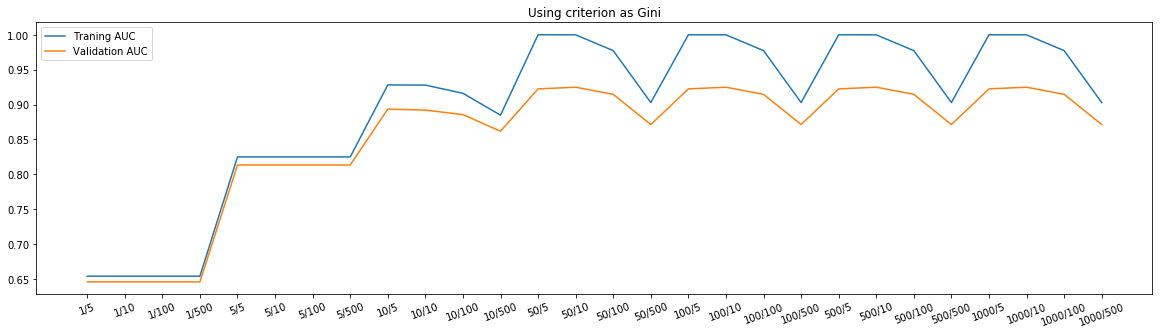

In [223]:
plt.figure(figsize=(20,5))
plt.plot(range(len(XLabels[:28])), auc_aw_tr)
plt.plot(range(len(XLabels[:28])), auc_aw_cv)
plt.xticks(range(len(XLabels[:28])), XLabels[:28], rotation = 20)
plt.legend(['Traning AUC', 'Validation AUC'])
plt.title("Using criterion as Gini")
plt.show()

#### min_samples_split = 50 and max_depth = 500 Criterion = "Gini"

In [224]:
DT_clf_aw = DecisionTreeClassifier(random_state=0, min_samples_split = 50, max_depth=500)
DT_clf_aw.fit(sent_vectors_train_aw, Y_train_split_aw)
Y_pred_tr = DT_clf_aw.predict(sent_vectors_train_aw)
auc_opt_tr_aw = roc_auc_score(Y_train_split_aw, Y_pred_tr)
Y_pred_test = DT_clf_aw.predict(sent_vectors_test_aw)
auc_opt_test_aw = roc_auc_score(Y_test_aw, Y_pred_test)
print("AUC value of train data: ",auc_opt_tr_aw)
print("AUC value of test data: ", auc_opt_test_aw)

AUC value of train data:  0.9455411314954508
AUC value of test data:  0.8793396628191745


In [225]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(Y_train_split_aw, Y_pred_tr)
fpr_test, tpr_test, _ = roc_curve(Y_test_aw, Y_pred_test)
print("AUC Train: %0.4f AUC Test: %0.4f"%(auc(fpr, tpr),(auc(fpr_test, tpr_test))))

AUC Train: 0.9455 AUC Test: 0.8793


In [226]:
def plotROC(fpr, tpr, fpr_test, tpr_test, auc_tr, auc_test): 
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC on train data = %0.3f' % auc_tr)
    plt.plot(fpr_test, tpr_test, 'g', label = 'AUC on test data = %0.3f' % auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

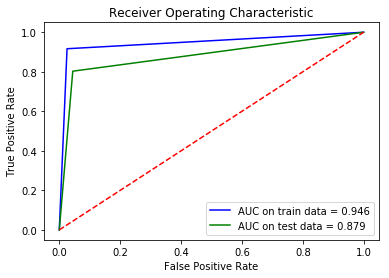

In [227]:
plotROC(fpr, tpr, fpr_test, tpr_test, auc_opt_tr_aw, auc_opt_test_aw)

In [228]:
#confusion matirx
import scikitplot.metrics as skplt

def plotConfusion(Y_tr,Y_prob_tr, Y_ts, Y_prob_ts):
    # for train data prediction
    skplt.plot_confusion_matrix(Y_tr, Y_prob_tr)
    #for test data prediction
    skplt.plot_confusion_matrix(Y_ts, Y_prob_ts)

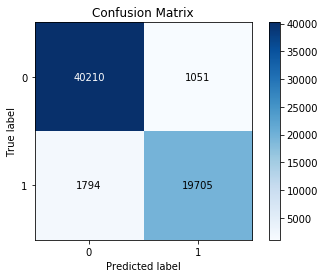

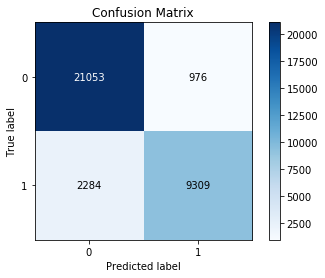

In [229]:
plotConfusion(Y_train_split_aw, Y_pred_tr,Y_test_aw,Y_pred_test)

In [230]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision of test: %0.4f"%(precision_score(Y_test_aw, Y_pred_test)))
print("Recall of test: %0.4f"%(recall_score(Y_test_aw, Y_pred_test)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test_aw, Y_pred_test)))

Precision of test: 0.9051
Recall of test: 0.8030
F1 Score of test: 0.8510


## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [231]:
sent_vectors_train_tw = np.load("tfidf_sent_vectors_tw_train.npy")
sent_vectors_CV_tw = np.load("tfidf_sent_vectors_tw_CV.npy")
sent_vectors_test_tw = np.load("tfidf_sent_vectors_tw_test.npy")
Y_train_split_tw = np.load("Y_train_split_tw.npy")
Y_CV_tw = np.load("Y_CV_tw.npy")
Y_test_tw = np.load("Y_test_tw.npy")

In [232]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate until the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [233]:
# Please write all the code with proper documentation
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

max_depth = [1, 5, 10, 50, 100, 500, 1000]
min_samples_split = [5, 10, 100, 500]
Y_pred_tw_tr = []
Y_pred_tw_cv = []
auc_tw_tr=[]
auc_tw_cv=[]
XLabels=[]

for depth in max_depth:
    for min_sam in min_samples_split:
        temp = str(depth)+"/"+str(min_sam)
        XLabels.append(temp)
        clf = DecisionTreeClassifier(random_state=0, min_samples_split = min_sam, max_depth=depth, criterion="gini")
        clf.fit(sent_vectors_train_tw, Y_train_split_tw)
        #Predict on train data - Probability Values
        Y_pred_tw_tr = batch_predict(clf, sent_vectors_train_tw)
        #Predict on CV data - Probability vlaues
        Y_pred_tw_cv = batch_predict(clf, sent_vectors_CV_tw)
         #Get AUC Value for train data
        temp_auc_tr = roc_auc_score(Y_train_split_tw, Y_pred_tw_tr)
        auc_tw_tr.append(temp_auc_tr)
        #Get AUC Value
        temp_auc_cv = roc_auc_score(Y_CV_tw, Y_pred_tw_cv)
        auc_tw_cv.append(temp_auc_cv)
        print("max_dept: %d min_samples: %d AUC_Train: %0.4f AUC_CV: %0.4f"%(depth, min_sam, temp_auc_tr, temp_auc_cv))

max_dept: 1 min_samples: 5 AUC_Train: 0.6442 AUC_CV: 0.6455
max_dept: 1 min_samples: 10 AUC_Train: 0.6442 AUC_CV: 0.6455
max_dept: 1 min_samples: 100 AUC_Train: 0.6442 AUC_CV: 0.6455
max_dept: 1 min_samples: 500 AUC_Train: 0.6442 AUC_CV: 0.6455
max_dept: 5 min_samples: 5 AUC_Train: 0.7903 AUC_CV: 0.7798
max_dept: 5 min_samples: 10 AUC_Train: 0.7903 AUC_CV: 0.7798
max_dept: 5 min_samples: 100 AUC_Train: 0.7903 AUC_CV: 0.7798
max_dept: 5 min_samples: 500 AUC_Train: 0.7898 AUC_CV: 0.7791
max_dept: 10 min_samples: 5 AUC_Train: 0.9108 AUC_CV: 0.8688
max_dept: 10 min_samples: 10 AUC_Train: 0.9109 AUC_CV: 0.8692
max_dept: 10 min_samples: 100 AUC_Train: 0.8965 AUC_CV: 0.8616
max_dept: 10 min_samples: 500 AUC_Train: 0.8597 AUC_CV: 0.8370
max_dept: 50 min_samples: 5 AUC_Train: 1.0000 AUC_CV: 0.9167
max_dept: 50 min_samples: 10 AUC_Train: 0.9998 AUC_CV: 0.9181
max_dept: 50 min_samples: 100 AUC_Train: 0.9711 AUC_CV: 0.9042
max_dept: 50 min_samples: 500 AUC_Train: 0.8785 AUC_CV: 0.8474
max_dept: 10

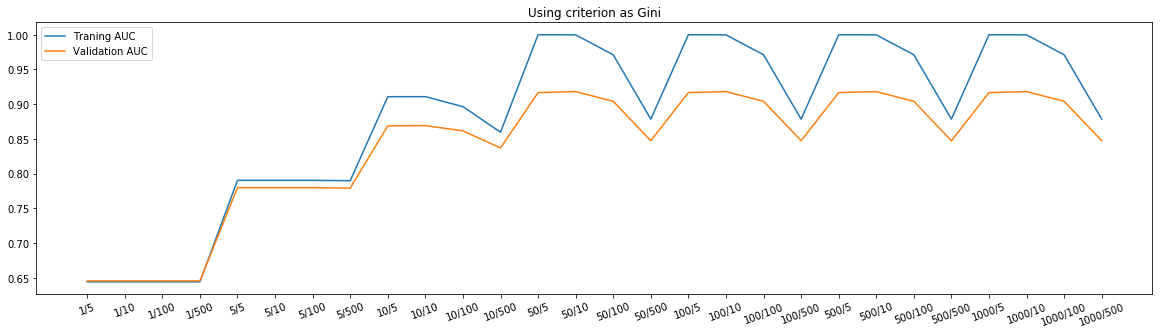

In [235]:
plt.figure(figsize=(20,5))
plt.plot(range(len(XLabels)), auc_tw_tr)
plt.plot(range(len(XLabels)), auc_tw_cv)
plt.xticks(range(len(XLabels)), XLabels, rotation = 20)
plt.legend(['Traning AUC', 'Validation AUC'])
plt.title("Using criterion as Gini")
plt.show()

#### min_samples_split = 50 and max_depth = 500 Criterion = "Gini"

In [236]:
DT_clf_tw = DecisionTreeClassifier(random_state=0, min_samples_split = 50, max_depth=500)
DT_clf_tw.fit(sent_vectors_train_tw, Y_train_split_tw)
Y_pred_tr = DT_clf_tw.predict(sent_vectors_train_tw)
auc_opt_tr_tw = roc_auc_score(Y_train_split_tw, Y_pred_tr)
Y_pred_test = DT_clf_tw.predict(sent_vectors_test_tw)
auc_opt_test_tw = roc_auc_score(Y_test_tw, Y_pred_test)
print("AUC value of train data: ",auc_opt_tr_tw)
print("AUC value of test data: ", auc_opt_test_tw)

AUC value of train data:  0.9321879928450253
AUC value of test data:  0.8574316618348813


In [237]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(Y_train_split_tw, Y_pred_tr)
fpr_test, tpr_test, _ = roc_curve(Y_test_tw, Y_pred_test)
print("AUC Train: %0.4f AUC Test: %0.4f"%(auc(fpr, tpr),(auc(fpr_test, tpr_test))))

AUC Train: 0.9322 AUC Test: 0.8574


In [238]:
def plotROC(fpr, tpr, fpr_test, tpr_test, auc_tr, auc_test): 
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC on train data = %0.3f' % auc_tr)
    plt.plot(fpr_test, tpr_test, 'g', label = 'AUC on test data = %0.3f' % auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

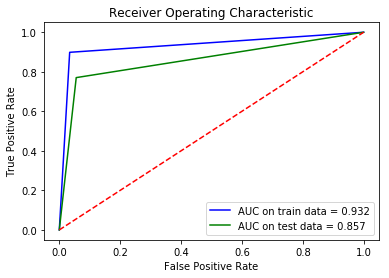

In [239]:
plotROC(fpr, tpr, fpr_test, tpr_test, auc_opt_tr_tw, auc_opt_test_tw)

In [240]:
#confusion matirx
import scikitplot.metrics as skplt

def plotConfusion(Y_tr,Y_prob_tr, Y_ts, Y_prob_ts):
    # for train data prediction
    skplt.plot_confusion_matrix(Y_tr, Y_prob_tr)
    #for test data prediction
    skplt.plot_confusion_matrix(Y_ts, Y_prob_ts)

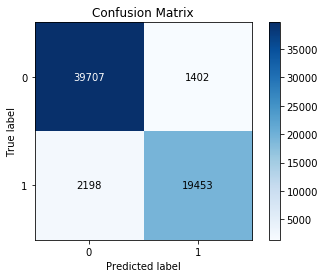

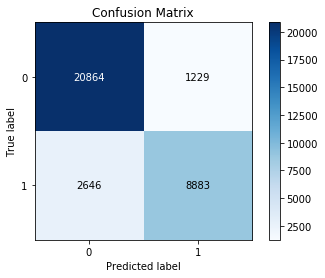

In [241]:
plotConfusion(Y_train_split_tw, Y_pred_tr,Y_test_tw,Y_pred_test)

In [244]:
import pickle
filename_bow = 'DT_clf.sav'
filename_aw = 'DT_clf_aw.sav'
filename_tw = 'DT_clf_tw.sav'
filename_tf = 'DT_clf_tf.sav'
pickle.dump(DT_clf, open(filename_bow,'wb'))
pickle.dump(DT_clf_tf, open(filename_tf,'wb'))
pickle.dump(DT_clf_aw, open(filename_aw,'wb'))
pickle.dump(DT_clf_tw, open(filename_tw,'wb'))

In [1]:
import pickle

filename_bow = 'DT_clf.sav'
filename_aw = 'DT_clf_aw.sav'
filename_tw = 'DT_clf_tw.sav'
filename_tf = 'DT_clf_tf.sav'

loaded_model_bow = pickle.load(open(filename_bow, 'rb'))

In [243]:
from prettytable import PrettyTable
X = PrettyTable()


X.field_names = ["vectorizer","Optimal-min_samples_split Value", "max_depth","AUC on train","AUC on Test"]
X.add_row(["BoW",10, 500, auc_opt_tr_bow,auc_opt_test_bow])
X.add_row(["TfIdf",50, 500,auc_opt_tr_tf,auc_opt_test_tf ])
X.add_row(["Avg W2V",50, 500, auc_opt_tr_aw,auc_opt_test_aw])
X.add_row(["TfIdf W2V",50, 500, auc_opt_tr_tw, auc_opt_test_tw])
print(X)

+------------+---------------------------------+-----------+--------------------+--------------------+
| vectorizer | Optimal-min_samples_split Value | max_depth |    AUC on train    |    AUC on Test     |
+------------+---------------------------------+-----------+--------------------+--------------------+
|    BoW     |                10               |    500    | 0.9893843403930606 | 0.8999990661273116 |
|   TfIdf    |                50               |    500    | 0.9625323236773774 | 0.8887860359658792 |
|  Avg W2V   |                50               |    500    | 0.9455411314954508 | 0.8793396628191745 |
| TfIdf W2V  |                50               |    500    | 0.9321879928450253 | 0.8574316618348813 |
+------------+---------------------------------+-----------+--------------------+--------------------+


# [6] Conclusions

* Upsampled data works well than imbalanced dataset
* Increasing number of important features would make W2V- Avg/TfIdf model to perform well on unseen data
* The min_samples_split - less than 50 doesnt perform well on training and validation set
* Min_Samples_split - more than 50 usually creates same pattern w.r.t different max_depth value.
* Compared to all vectorization method - BoW has mroe gap between performance on training data and test data, as we can see abvoe it has almost 8% difference.